In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from keras.preprocessing.sequence import TimeseriesGenerator
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.callbacks import Callback
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import plot_model
from keras.callbacks import EarlyStopping
from sklearn.metrics import mean_squared_error
from math import sqrt
from sklearn.metrics import mean_absolute_error

import warnings
warnings.filterwarnings("ignore")

In [2]:
raw_df = pd.read_csv('UoW_load.csv')
raw_df.head()

,Dates,9:00,10:00,11:00
0,1/1/2018,89.4,90.6,88.6
1,1/2/2018,108.2,104.6,106.0
2,1/3/2018,110.0,111.6,114.8
3,1/4/2018,106.4,104.4,109.0
4,1/5/2018,97.8,100.4,102.4


In [3]:
raw_df.rename(columns = {'Dates ':'Dates'}, inplace = True)

In [4]:
raw_df.dtypes

Dates     object
9:00     float64
10:00    float64
11:00    float64
dtype: object

In [5]:
# convert Dates column to datatime format
raw_df['Dates'] = pd.to_datetime(raw_df['Dates'], infer_datetime_format=True)

array([<AxesSubplot:xlabel='Dates'>, <AxesSubplot:xlabel='Dates'>,
       <AxesSubplot:xlabel='Dates'>], dtype=object)

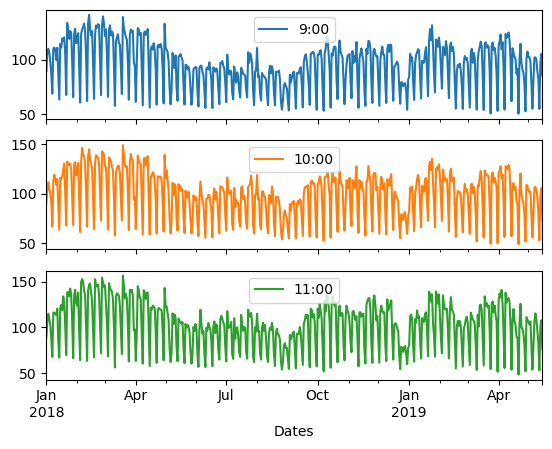

In [6]:
raw_df.set_index('Dates').plot(subplots=True)

In [7]:
input_df = raw_df.copy()
input_df = input_df.drop('Dates', axis=1)
input_df.describe()

,9:00,10:00,11:00
count,500.00000,500.000000,500.000000
mean,95.34920,99.627600,102.829600
std,20.97215,22.937212,25.271653
min,50.40000,49.200000,48.200000
25%,81.55000,83.000000,84.750000
50%,97.50000,102.800000,105.400000
75%,110.60000,116.050000,120.900000
max,141.20000,148.800000,156.400000


In [8]:
# scale the dataset
scaler = MinMaxScaler()
scaled_df = scaler.fit_transform(input_df)

scaled_df

array([[0.42951542, 0.41566265, 0.37338262],
       [0.63656388, 0.5562249 , 0.53419593],
       [0.65638767, 0.62650602, 0.6155268 ],
       ...,
       [0.51101322, 0.47389558, 0.48613678],
       [0.60572687, 0.56626506, 0.54898336],
       [0.38325991, 0.23895582, 0.25878004]])

In [9]:
features = scaled_df.copy() # 9:00, 10:00 and 11:00 features
target = scaled_df[:, 2] # only the 11:00 feature

In [10]:
x_train, x_test, y_train, y_test = train_test_split(features, target, test_size=0.14, random_state=123, shuffle=False)

In [11]:
print("Train set :", x_train.shape)
print("Test set :", x_test.shape)

Train set : (430, 3)
Test set : (70, 3)


In [12]:
def generate_inputs(n_input, n_features=3, batch_size=1):
    train_generator = TimeseriesGenerator(x_train, y_train, length=n_input, batch_size=batch_size, sampling_rate=1)
    test_generator = TimeseriesGenerator(x_test, y_test, length=n_input, batch_size=batch_size, sampling_rate=1)
    
    return train_generator, test_generator

### Model with Two Hidden Layers and Consider Previous 12 Hours (model_1)

In [13]:
n_input=12
n_features=3
batch_size=1
train_generator, test_generator = generate_inputs(n_input, n_features, batch_size)

In [14]:
# define model
model_1 = Sequential()
model_1.add(LSTM(64, activation='relu', input_shape=(n_input, n_features), return_sequences=True))
model_1.add(LSTM(32, activation='relu', return_sequences=False))
model_1.add(Dense(1))

model_1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 12, 64)            17408     
                                                                 
 lstm_1 (LSTM)               (None, 32)                12416     
                                                                 
 dense (Dense)               (None, 1)                 33        
                                                                 
Total params: 29,857
Trainable params: 29,857
Non-trainable params: 0
_________________________________________________________________


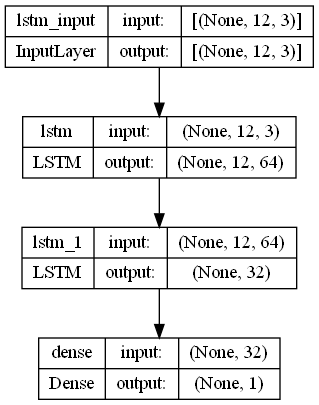

In [15]:
# Plot the model structure
plot_model(model_1, to_file='multi_model_1.png', show_shapes=True)

In [25]:
# weights of each neurons for each layer 
def show_no_of_weigths(model):
    total_weigths = 0
    
    for i in range(len(model.layers)):
        
        weigths_per_layer = model.layers[i].get_weights()[0].size
        
        total_weigths += weigths_per_layer
        
        print('Layer ', i, ' weights :',  weigths_per_layer)
        
    print('Total No of Weigths Per Network :', total_weigths)

In [26]:
show_no_of_weigths(model_1)

Layer  0  weights : 768
Layer  1  weights : 8192
Layer  2  weights : 32
Total No of Weigths Per Network : 8992


In [21]:
print(model_1.layers[1].get_weights()[0].shape)

(64, 128)


In [22]:
early_stopping = EarlyStopping(monitor='val_loss', patience=2, mode='min')

model_1.compile(loss='mse', optimizer=Adam(learning_rate=0.001), metrics=['mean_absolute_error'])

model_1.fit_generator(train_generator, epochs=20, validation_data=test_generator, shuffle=False, callbacks=[early_stopping])

Epoch 1/20
418/418 [==============================] - 11s 15ms/step - loss: 0.0567 - mean_absolute_error: 0.1953 - val_loss: 0.0584 - val_mean_absolute_error: 0.2067
Epoch 2/20
418/418 [==============================] - 6s 14ms/step - loss: 0.0479 - mean_absolute_error: 0.1800 - val_loss: 0.0566 - val_mean_absolute_error: 0.2029
Epoch 3/20
418/418 [==============================] - 6s 13ms/step - loss: 0.0328 - mean_absolute_error: 0.1458 - val_loss: 0.0349 - val_mean_absolute_error: 0.1574
Epoch 4/20
418/418 [==============================] - 6s 15ms/step - loss: 0.0245 - mean_absolute_error: 0.1277 - val_loss: 0.0374 - val_mean_absolute_error: 0.1639
Epoch 5/20
418/418 [==============================] - 6s 14ms/step - loss: 0.0217 - mean_absolute_error: 0.1201 - val_loss: 0.0269 - val_mean_absolute_error: 0.1331
Epoch 6/20
418/418 [==============================] - 6s 15ms/step - loss: 0.0191 - mean_absolute_error: 0.1113 - val_loss: 0.0307 - val_mean_absolute_error: 0.1440
Epoch 7/2

In [38]:
def plot_loss(p_model):
    loss_per_epoch = p_model.history.history['loss']
    plt.plot(range(len(loss_per_epoch)), loss_per_epoch)

In [19]:
model_1.evaluate_generator(test_generator, verbose=0)

[0.014049693010747433, 0.09541867673397064]

In [20]:
predictions = model_1.predict_generator(test_generator)
predictions.shape

(58, 1)

In [22]:
len(x_test)

70

In [23]:
# create new dataframe by concatting both predictions and 9:00, 10:00 from test set 
# with same number of raws as in prediction set
df_pred = pd.concat([pd.DataFrame(predictions), pd.DataFrame(x_test[:,:2][n_input:])], axis=1)
df_pred.head()

,0,0,1
0,0.659853,0.722467,0.712851
1,0.649163,0.667401,0.698795
2,0.640461,0.691630,0.700803
3,0.616752,0.671806,0.668675
4,0.397006,0.425110,0.379518


In [24]:
def create_dataset_for_plotting(p_scaler, p_df_pred, p_predictions, p_raw_df):
    rev_trans = p_scaler.inverse_transform(p_df_pred) # inverse transform dataset to it's original form

    df_final = input_df[p_predictions.shape[0]*-1:] # get last 58 (size of predictions) records from original dataset
    df_final['Date'] = p_raw_df['Dates'][p_predictions.shape[0]*-1:] # get and add 'Date' column from original dataset
    df_final['Predicted_11:00'] = rev_trans[:, 0] # get and add last column from prediction that means 11:00 hour values 
    df_final = df_final.drop(['9:00', '10:00'], axis=1) # remove '9:00', '10:00' column from plotting 
    date_indexed_df = df_final.set_index('Date') # make 'Date' column as the index column

    return date_indexed_df

In [25]:
date_indexed_df = create_dataset_for_plotting(scaler, df_pred, predictions, raw_df)
date_indexed_df.head()

,11:00,Predicted_11:00
Date,,
2019-03-19,124.0,110.314613
2019-03-20,126.2,109.344017
2019-03-21,121.8,108.553861
2019-03-22,123.8,106.401122
2019-03-23,95.6,86.448110


<AxesSubplot:title={'center':'11th Hour Electricity Load Prediction vs Test Data'}, xlabel='Date'>

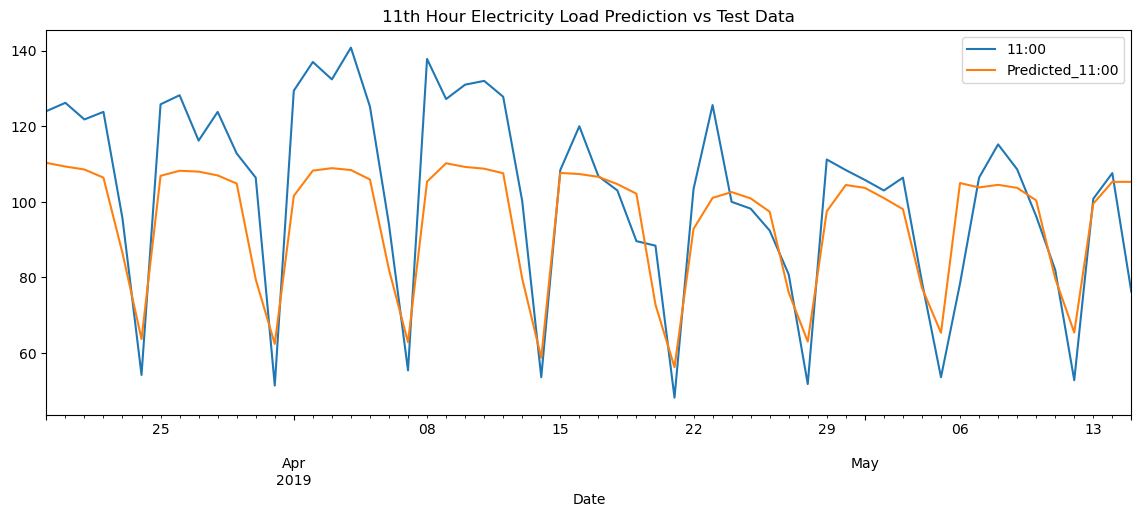

In [26]:
date_indexed_df.plot(figsize=(14,5), title='11th Hour Electricity Load Prediction vs Test Data')

In [29]:
def check_performances_indices(test_data, pred_data):
    rmse=sqrt(mean_squared_error(test_data, pred_data))
    print('RMSE:', rmse)
    
    mae = mean_absolute_error(test_data, pred_data)
    print('MAE:', mae)
    
    abs_pct_error = np.abs((test_data - pred_data) / test_data)
    mape = np.mean(abs_pct_error) * 100
    print('MAPE:', mape)

In [31]:
check_performances_indices(date_indexed_df['11:00'], date_indexed_df['Predicted_11:00'])

RMSE: 15.51590490016175
MAE: 12.653637285890259
MAPE: 12.53729176143829


### Model with One Hidden Layers and Consider Previous 12 Hours (model_2)

In [27]:
n_input=12
n_features=3
batch_size=1
train_generator_2, test_generator_2 = generate_inputs(n_input, n_features, batch_size)

In [28]:
# define model
model_2 = Sequential()
model_2.add(LSTM(64, activation='relu', input_shape=(n_input, n_features)))
model_2.add(Dense(1))

model_2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 64)                17408     
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 17,473
Trainable params: 17,473
Non-trainable params: 0
_________________________________________________________________


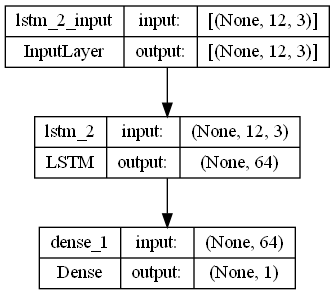

In [29]:
# Plot the model structure
plot_model(model_2, to_file='multi_model_2.png', show_shapes=True)

In [30]:
show_no_of_weigths(model_2)

Layer  0  weights : 768
Layer  1  weights : 64
Total No of Weigths Per Network : 832


In [36]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5, mode='min')

model_2.compile(loss='mse', optimizer=Adam(learning_rate=0.001), metrics=['mean_absolute_error'])

model_2.fit_generator(test_generator_2, epochs=20, validation_data=train_generator_2, shuffle=False, callbacks=[early_stopping])

Epoch 1/20
58/58 [==============================] - 5s 33ms/step - loss: 0.1244 - mean_absolute_error: 0.2857 - val_loss: 0.0577 - val_mean_absolute_error: 0.2150
Epoch 2/20
58/58 [==============================] - 2s 26ms/step - loss: 0.0614 - mean_absolute_error: 0.2033 - val_loss: 0.0584 - val_mean_absolute_error: 0.2155
Epoch 3/20
58/58 [==============================] - 2s 26ms/step - loss: 0.0601 - mean_absolute_error: 0.2002 - val_loss: 0.0580 - val_mean_absolute_error: 0.2140
Epoch 4/20
58/58 [==============================] - 2s 27ms/step - loss: 0.0588 - mean_absolute_error: 0.1992 - val_loss: 0.0563 - val_mean_absolute_error: 0.2102
Epoch 5/20
58/58 [==============================] - 2s 32ms/step - loss: 0.0570 - mean_absolute_error: 0.1962 - val_loss: 0.0550 - val_mean_absolute_error: 0.2070
Epoch 6/20
58/58 [==============================] - 2s 30ms/step - loss: 0.0555 - mean_absolute_error: 0.1929 - val_loss: 0.0550 - val_mean_absolute_error: 0.2067
Epoch 7/20
58/58 [====

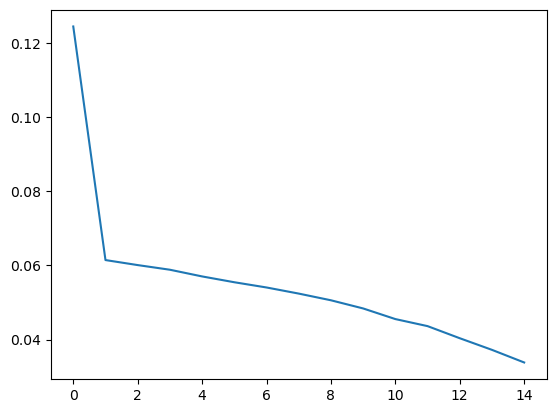

In [39]:
plot_loss(model_2)

In [40]:
predictions_2 = model_2.predict_generator(test_generator_2)
predictions_2.shape

(58, 1)

In [41]:
# create new dataframe by concatting both predictions and 9:00, 10:00 from test set 
# with same number of raws as in prediction set
df_pred_2 = pd.concat([pd.DataFrame(predictions_2), pd.DataFrame(x_test[:,:2][n_input:])], axis=1)
df_pred_2.head()

,0,0,1
0,0.502369,0.722467,0.712851
1,0.476306,0.667401,0.698795
2,0.439944,0.691630,0.700803
3,0.406904,0.671806,0.668675
4,0.369198,0.425110,0.379518


In [42]:
date_indexed_df_2 = create_dataset_for_plotting(scaler, df_pred_2, predictions_2, raw_df)
date_indexed_df_2.head()

,11:00,Predicted_11:00
Date,,
2019-03-19,124.0,96.015072
2019-03-20,126.2,93.648619
2019-03-21,121.8,90.346950
2019-03-22,123.8,87.346909
2019-03-23,95.6,83.923208


<AxesSubplot:title={'center':'11th Hour Electricity Load Prediction vs Test Data'}, xlabel='Date'>

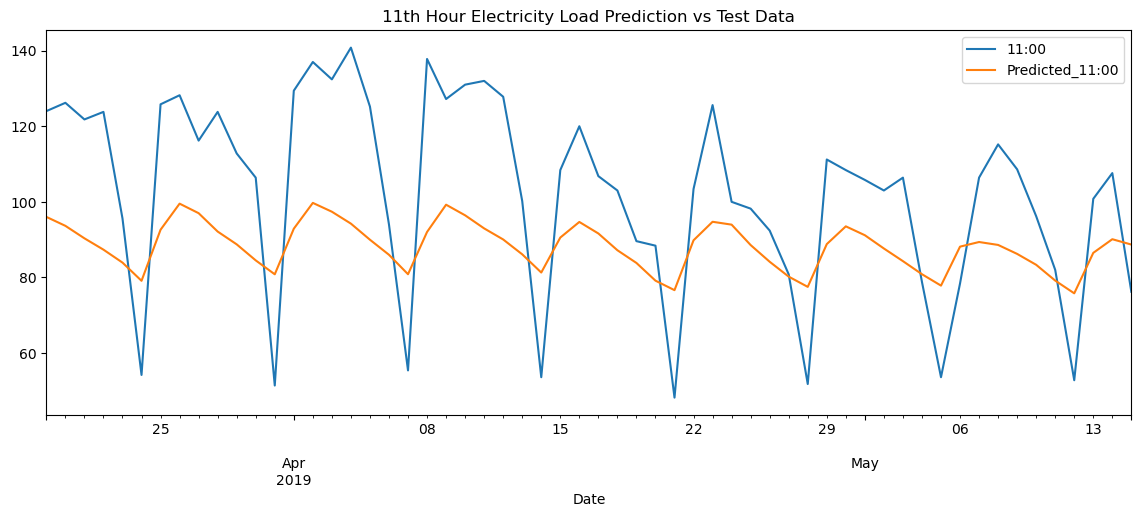

In [43]:
date_indexed_df_2.plot(figsize=(14,5), title='11th Hour Electricity Load Prediction vs Test Data')

In [44]:
check_performances_indices(date_indexed_df_2['11:00'], date_indexed_df_2['Predicted_11:00'])

RMSE: 24.83374905569191
MAE: 22.25325473999156
MAPE: 22.79550143006028


### Model with Two Hidden Layers and Consider Previous 7 Hours (model_3)

In [31]:
n_input_3=7
n_features_3=3
batch_size_3=1
train_generator_3, test_generator_3 = generate_inputs(n_input_3, n_features_3, batch_size_3)

In [32]:
# define model
model_3 = Sequential()
model_3.add(LSTM(64, activation='relu', input_shape=(n_input_3, n_features_3), return_sequences=True))
model_3.add(LSTM(32, activation='relu', return_sequences=False))
model_3.add(Dense(1))

model_3.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, 7, 64)             17408     
                                                                 
 lstm_4 (LSTM)               (None, 32)                12416     
                                                                 
 dense_2 (Dense)             (None, 1)                 33        
                                                                 
Total params: 29,857
Trainable params: 29,857
Non-trainable params: 0
_________________________________________________________________


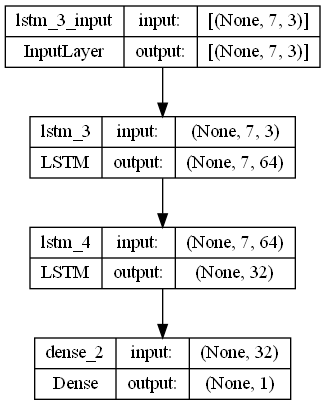

In [33]:
# Plot the model structure
plot_model(model_3, to_file='multi_model_3.png', show_shapes=True)

In [34]:
show_no_of_weigths(model_3)

Layer  0  weights : 768
Layer  1  weights : 8192
Layer  2  weights : 32
Total No of Weigths Per Network : 8992


In [51]:
early_stopping = EarlyStopping(monitor='val_loss', patience=4, mode='min')

model_3.compile(loss='mse', optimizer=Adam(learning_rate=0.001), metrics=['mean_absolute_error'])

model_3.fit_generator(test_generator_3, epochs=20, validation_data=train_generator_3, shuffle=False, callbacks=[early_stopping])

Epoch 1/20
63/63 [==============================] - 7s 37ms/step - loss: 0.1635 - mean_absolute_error: 0.3238 - val_loss: 0.0427 - val_mean_absolute_error: 0.1766
Epoch 2/20
63/63 [==============================] - 2s 27ms/step - loss: 0.0514 - mean_absolute_error: 0.1787 - val_loss: 0.0490 - val_mean_absolute_error: 0.1950
Epoch 3/20
63/63 [==============================] - 2s 31ms/step - loss: 0.0484 - mean_absolute_error: 0.1721 - val_loss: 0.0460 - val_mean_absolute_error: 0.1876
Epoch 4/20
63/63 [==============================] - 2s 31ms/step - loss: 0.0430 - mean_absolute_error: 0.1610 - val_loss: 0.0422 - val_mean_absolute_error: 0.1780
Epoch 5/20
63/63 [==============================] - 2s 29ms/step - loss: 0.0369 - mean_absolute_error: 0.1508 - val_loss: 0.0377 - val_mean_absolute_error: 0.1658
Epoch 6/20
63/63 [==============================] - 2s 29ms/step - loss: 0.0316 - mean_absolute_error: 0.1432 - val_loss: 0.0342 - val_mean_absolute_error: 0.1560
Epoch 7/20
63/63 [====

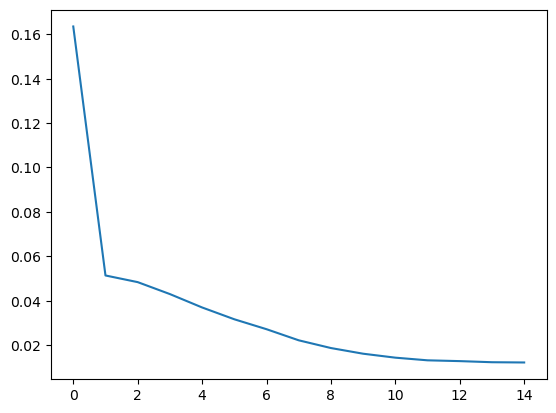

In [52]:
plot_loss(model_3)

In [53]:
predictions_3 = model_3.predict_generator(test_generator_3)
predictions_3.shape

(63, 1)

In [54]:
# create new dataframe by concatting both predictions and 9:00, 10:00 from test set 
# with same number of raws as in prediction set
df_pred_3 = pd.concat([pd.DataFrame(predictions_3), pd.DataFrame(x_test[:,:2][n_input:])], axis=1)
df_pred_3.head()

,0,0,1
0,0.492661,0.722467,0.712851
1,0.468698,0.667401,0.698795
2,0.268838,0.691630,0.700803
3,0.042993,0.671806,0.668675
4,0.487940,0.425110,0.379518


In [55]:
date_indexed_df_3 = create_dataset_for_plotting(scaler, df_pred_3, predictions_3, raw_df)
date_indexed_df_3.head()

,11:00,Predicted_11:00
Date,,
2019-03-14,124.8,95.133594
2019-03-15,119.0,92.957783
2019-03-16,89.4,74.810514
2019-03-17,58.2,54.303745
2019-03-18,133.8,94.704994


<AxesSubplot:title={'center':'11th Hour Electricity Load Prediction vs Test Data'}, xlabel='Date'>

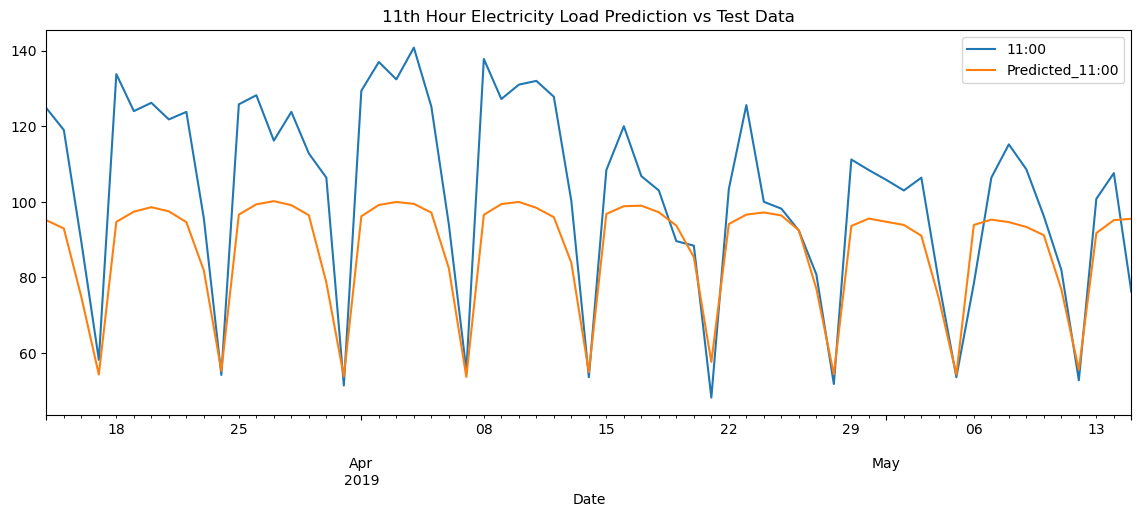

In [56]:
date_indexed_df_3.plot(figsize=(14,5), title='11th Hour Electricity Load Prediction vs Test Data')

In [57]:
check_performances_indices(date_indexed_df_3['11:00'], date_indexed_df_3['Predicted_11:00'])

RMSE: 20.489502735606006
MAE: 16.662520297652204
MAPE: 14.659503993228967
